(77, 26)


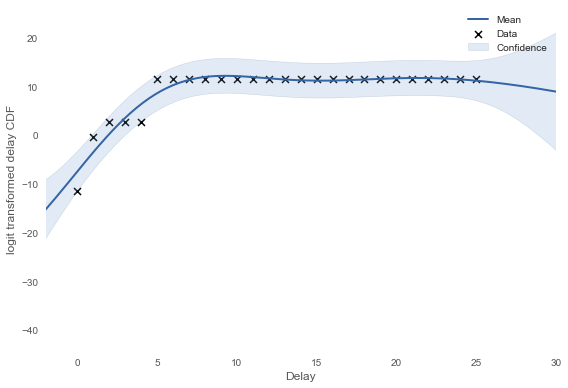

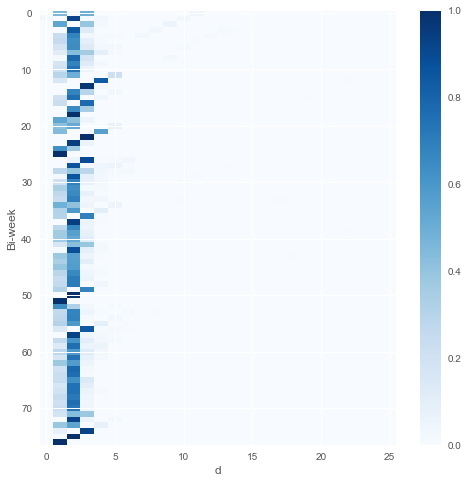

In [336]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout
            
            
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams['lines.linewidth']=1
plt.rcParams['axes.facecolor']='w'

n_t_d = []
with open("province-biweek_with_delays.csv") as f:
    i = 0
    for line in f.readlines():
        if i > 0:
            n_t_d.append(line.replace("\n","").split(','))
        i+=1

n_t_d_1 = []

for elm in n_t_d:
    if elm[2] == "10":
        n_t_d_1.append(elm)


index_to_dates = {}
dates_to_index = {}
count = 0
for i in ["2014","2015","2016"]:
    for j in range(1,27):
        index_to_dates[count] = str(i)+str(j)
        dates_to_index[str(i)+str(j)] = count
        count +=1
        
reporting_matrix = np.zeros((26*3,26*3))

for elm in n_t_d_1:
    try:
        sick_date = elm[0]+elm[1]
        report_date = elm[-2] + elm[-1]
        cases = elm[3]
        reporting_matrix_row = dates_to_index[sick_date] 
        reporting_matrix_col =  dates_to_index[report_date] 
        reporting_matrix[reporting_matrix_row,reporting_matrix_col] = int(cases)
    except:
        pass
#np.set_printoptions(threshold=np.nan)


D=26
n_t_d = np.zeros((len(reporting_matrix),D))

for i in range(len(reporting_matrix)):
    for j in range(i,i+D):
        try:
            n_t_d[i,j-i] = reporting_matrix[i][j]
        except:
            pass
n_t_d = n_t_d[:-1]
p_hat = []
from matplotlib.pyplot import cm

for i in range(len(n_t_d)):
    p_hat.append(n_t_d[i]/np.sum(n_t_d[i]))
    
p_hat = np.array(p_hat)
print (p_hat.shape)
plt.figure(figsize=(8,8))
plt.ylabel("Bi-week")
plt.xlabel("d")
plt.imshow(p_hat,aspect='auto',cmap=cm.Blues)
plt.legend()
plt.colorbar()
plt.show()

(2002,)
[ 0  1  2 ... 23 24 25]
(2002, 2002)


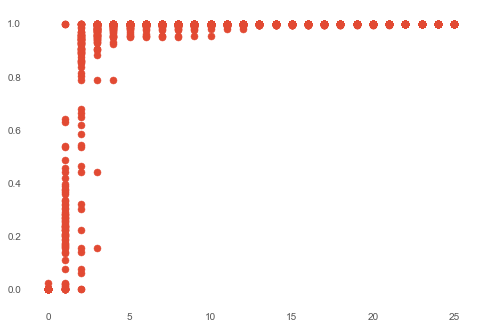

In [242]:


from matplotlib import animation as ani, pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from theano import shared, tensor as tt


def norm_cdf(z):
    return 0.5 * (1 + tt.erf(z / np.sqrt(2)))

p_cum_sum = np.cumsum(p_hat,axis=1).flatten() 
print (p_cum_sum.shape)
x = np.repeat(np.arange(26).reshape((-1,1)),77,axis=1).flatten('F')
print (x)
print (len(x),len(p_cum_sum))
plt.scatter(x,p_cum_sum)
plt.show()

In [243]:
print hierarchical_trace['alpha']

KeyError: 'Unknown variable alpha'

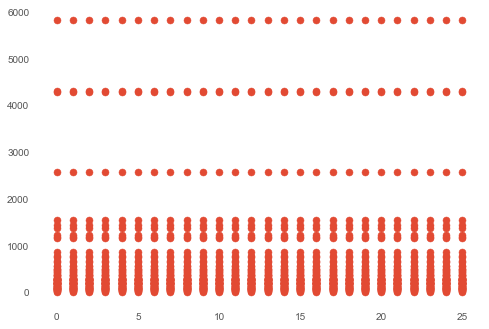

logp = -62,704, ||grad|| = 127.51: 100%|██████████| 13/13 [00:00<00:00, 1020.65it/s] 
100%|██████████| 3000/3000 [00:02<00:00, 1057.58it/s]


In [244]:
d = range(26)
x = []
y= []
off = []

for row in range(len(n_t_d)):
    row_cum_sum = np.cumsum(n_t_d[row])
    row_inf = np.sum(n_t_d[row])
    for rc in range(len(row_cum_sum)):
         y.append(row_cum_sum[rc])
         off.append(row_inf)
         x.append(rc)

plt.scatter(x,off)
plt.show()

with pm.Model() as pooled_model:
    b_intr = pm.Normal('b_intr', mu=0, sd=100 )
    b_tst = pm.Normal('b_tst', mu=0, sd=100 )
    

    # Expected value
    y_est = np.exp(b_intr + \
            b_tst * x + np.log(off))

    # Data likelihood
    y_like = pm.Poisson('y_like', mu=y_est, observed=y)

with pooled_model:
    start = pm.find_MAP()
    hierarchical_trace = pm.sample(2000, step=pm.Metropolis(), start=start, tune=1000)

(-0.31289535777328864, 0.01779909603929918)
{'b_intr': array(-0.3130674), 'b_tst': array(0.0178093)}


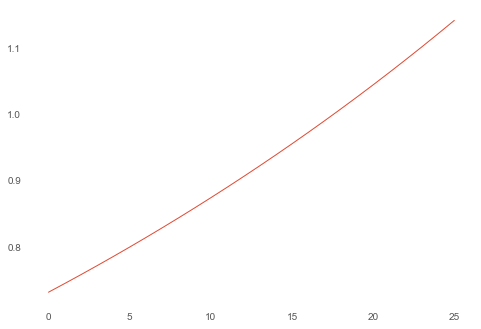

In [245]:
intercept,slope = np.mean(hierarchical_trace['b_intr']), np.mean(hierarchical_trace['b_tst'])

print (intercept,slope)
print (start)

plt.plot(np.exp(intercept + slope*np.arange(26)))
plt.show()


In [202]:
from scipy.special import expit
y_est_rep = []
for i in range(26):
    y_est_rep.append(intercept+slope* i)

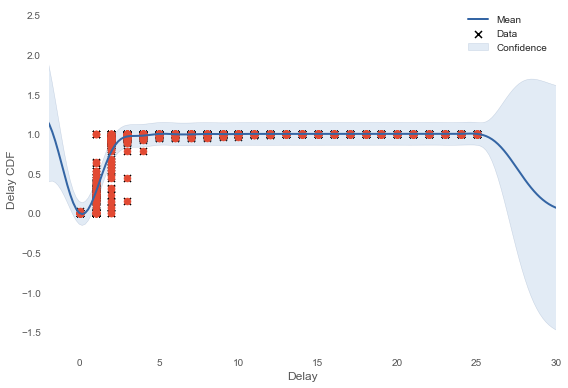

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s40  0001   1.898628e+03   3.868225e+05 
    09s14  0008  -2.312347e+03   9.381215e+02 
    18s80  0019  -2.335462e+03   4.897480e+00 
    22s03  0023  -2.335484e+03   1.584803e-07 
Runtime:     22s03
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6220897148724202,+ve,
rbf.lengthscale,1.94258934900602,+ve,
Gaussian_noise.variance,0.005267545750912045,+ve,


In [395]:
def logit(p):
    return p#np.log(p/(1-p))

def inv_logit(p):
    return p#np.exp(p) / (1 + np.exp(p))


#p_hat[p_hat <= 0] = 1e-10
#p_hat[p_hat >= 1] = 1-1e-10
p_hat_cum_sum = np.cumsum(p_hat,axis=1)
p_hat_cum_sum[p_hat_cum_sum <= 0] = 1e-10
p_hat_cum_sum[p_hat_cum_sum >= 1] = 1-1e-10
#print (p_hat_cum_sum)
#print (logit(p_hat_cum_sum))
#plt.scatter(range(len(logit(p_hat_cum_sum)[10,:])),logit(p_hat_cum_sum)[40,:])
#plt.ylabel("InvLogit of Proportion fo observed cases")
#plt.xlabel("delay value")
#plt.ylim(-.1,1.1)
#plt.show()
#plt.scatter(range(len(logit(p_hat_cum_sum)[:,10])),logit(p_hat_cum_sum)[:,3])
#plt.ylim(0,1.1)

#plt.show()


import GPy
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
bc = 26
X=[]
for row in range(len(p_hat)):
   X.append(np.arange(26))

X = np.array(X)

y = []



for row in range(len(p_hat)):
     y.append(np.array(logit(p_hat_cum_sum)[row,:]) )
y = np.array(y)

X = X.flatten().reshape((-1,1))
y = y.flatten().reshape((-1,1))

plt.scatter(X,y)
plt.show()




m = GPy.models.GPRegression(X,y,kernel)
m.optimize(messages=True)
plt.clf()
plt.cla()
plt.close()
display(m)
fig = m.plot(xlim=(-2,30),ylabel="Delay CDF",xlabel="Delay")
GPy.plotting.show(fig, filename='basic_gp_regression_notebook_optimized')


###
# IN SAMPLE
###

mse_dirichlet = []
mse_gp = []
for D_test in range(26):
    for row in range(len(n_t_d)):
        pred_p_gp = inv_logit(m.predict(np.array(D_test).reshape((-1,1))))[0][0][0]
        #print (pred_p_mle,pred_p_gp)
        pred_p_mle = np.cumsum(np.mean(p_hat,axis=0))[D_test]
        mse_dirichlet.append((np.cumsum(n_t_d[row])[D_test]/pred_p_mle-np.sum(n_t_d[row]))**2)
        mse_gp.append((np.cumsum(n_t_d[row])[D_test]/pred_p_gp-np.sum(n_t_d[row]))**2)
        
        


In [396]:
print np.mean(mse_dirichlet)
print np.mean(mse_gp)

183691.6082362996
75977.59544372368


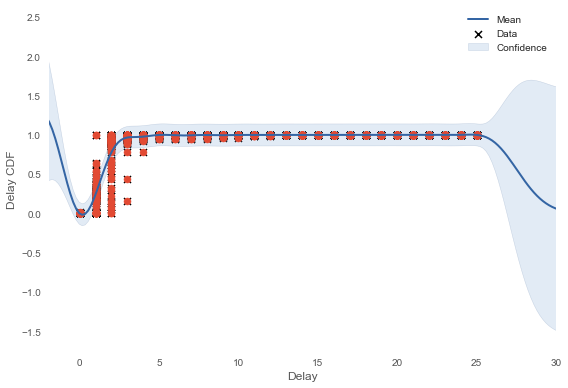

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    08s07  0007  -2.282951e+03   1.027502e+03 
    21s35  0021  -2.306138e+03   6.850131e+01 
    25s71  0026  -2.306175e+03   5.258020e-06 
Runtime:     25s71
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6191223082329016,+ve,
rbf.lengthscale,1.9092584246491295,+ve,
Gaussian_noise.variance,0.005252466775763509,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s45  0004   5.162102e+08   8.952007e+04 
    08s69  0010  -2.299200e+03   1.705537e-02 
    15s57  0018  -2.299201e+03   5.477595e-05 
Runtime:     15s57
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6224591603068863,+ve,
rbf.lengthscale,1.967233730515757,+ve,
Gaussian_noise.variance,0.005298977445412407,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s97  0002   1.159351e+03   5.871078e+05 
    08s43  0008  -2.305757e+03   4.859552e+01 
    12s46  0012  -2.305898e+03   1.919533e-03 
    14s15  0014  -2.305898e+03   1.048692e-03 
Runtime:     14s15
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6270426261154768,+ve,
rbf.lengthscale,1.9154632866208536,+ve,
Gaussian_noise.variance,0.005254486240196357,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s75  0002   1.160015e+03   5.869595e+05 
    11s37  0011  -2.298651e+03   4.953151e-01 
    15s93  0014  -2.298652e+03   1.008864e-04 
    17s66  0015  -2.298652e+03   1.008864e-04 
Runtime:     17s66
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6223014751004253,+ve,
rbf.lengthscale,1.958524719927045,+ve,
Gaussian_noise.variance,0.00530071346956078,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s04  0001   1.853465e+03   3.800138e+05 
    05s27  0004   5.190603e+08   6.705610e+05 
    16s06  0015  -2.293454e+03   4.544896e-05 
Runtime:     16s06
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6223770124591648,+ve,
rbf.lengthscale,1.955854622246429,+ve,
Gaussian_noise.variance,0.005328413093566644,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s06  0001   1.853501e+03   3.800029e+05 
    09s57  0008  -2.292436e+03   6.959273e+00 
    15s71  0014  -2.292486e+03   7.660586e-06 
Runtime:     15s71
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6225291541497882,+ve,
rbf.lengthscale,1.9510886867622679,+ve,
Gaussian_noise.variance,0.005332985960512118,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    06s58  0006  -2.288276e+03   8.160745e+03 
    15s68  0014  -2.292281e+03   4.049205e-06 
Runtime:     15s68
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6221560740823088,+ve,
rbf.lengthscale,1.951506494242545,+ve,
Gaussian_noise.variance,0.005334195802669688,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    04s73  0005  -2.068514e+03   2.739400e+05 
    09s65  0010  -2.299129e+03   5.036525e+00 
    13s34  0013  -2.299133e+03   2.778532e-04 
    14s50  0014  -2.299133e+03   2.778532e-04 
Runtime:     14s50
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6231286460560276,+ve,
rbf.lengthscale,1.937094230456483,+ve,
Gaussian_noise.variance,0.005294694688532365,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    02s19  0002   1.159744e+03   5.869882e+05 
    10s92  0010  -2.296800e+03   3.162371e+00 
    15s82  0014  -2.296813e+03   1.861297e-05 
    16s83  0015  -2.296813e+03   1.861297e-05 
Runtime:     16s83
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6210423708903052,+ve,
rbf.lengthscale,1.9543593765841973,+ve,
Gaussian_noise.variance,0.0053101036428719744,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    02s15  0002   1.159573e+03   5.869694e+05 
    12s36  0011  -2.292636e+03   2.720885e-01 
    16s96  0014  -2.292636e+03   1.793754e-05 
Runtime:     16s96
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6209945428758483,+ve,
rbf.lengthscale,1.9526499078766122,+ve,
Gaussian_noise.variance,0.005332513617398766,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    06s46  0004   5.186349e+08   5.089716e+05 
    14s03  0011  -2.294276e+03   5.516528e+00 
    18s00  0015  -2.294281e+03   7.150342e-05 
Runtime:     18s00
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6205824741288739,+ve,
rbf.lengthscale,1.9554444323503999,+ve,
Gaussian_noise.variance,0.005323995594739716,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    05s58  0006  -2.297986e+03   1.655584e+02 
    10s32  0011  -2.298136e+03   7.188909e-01 
    14s16  0014  -2.298137e+03   2.343013e-04 
Runtime:     14s16
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6213899858604991,+ve,
rbf.lengthscale,1.9485576848107469,+ve,
Gaussian_noise.variance,0.005301823939580993,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    12s78  0012  -2.397992e+03   1.535249e-01 
    20s83  0020  -2.397993e+03   3.293418e-02 
    23s74  0023  -2.397993e+03   2.502759e-07 
Runtime:     23s74
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6346377500586231,+ve,
rbf.lengthscale,1.947028023229581,+ve,
Gaussian_noise.variance,0.004785786075580317,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    04s24  0004   4.850528e+08   1.183230e-04 
    10s42  0010  -2.357754e+03   1.940637e+00 
    17s49  0018  -2.357760e+03   4.249014e-02 
    20s38  0021  -2.357760e+03   1.152102e-06 
Runtime:     20s38
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6132756346848967,+ve,
rbf.lengthscale,1.8887898826657603,+ve,
Gaussian_noise.variance,0.004979726960432022,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    09s34  0009  -2.298544e+03   3.541817e-02 
    16s34  0017  -2.298545e+03   2.106482e-02 
    18s99  0020  -2.298545e+03   4.592235e-06 
Runtime:     18s99
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6192384431000031,+ve,
rbf.lengthscale,1.9457075865566646,+ve,
Gaussian_noise.variance,0.005299488603246644,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    05s33  0006  -2.294288e+03   8.324633e+02 
    12s36  0014  -2.294739e+03   8.810561e-04 
Runtime:     12s36
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.618201060715679,+ve,
rbf.lengthscale,1.9585329658110386,+ve,
Gaussian_noise.variance,0.005322144415182532,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    10s54  0011  -2.321593e+03   1.039225e+00 
    14s56  0015  -2.321594e+03   3.117549e-03 
Runtime:     14s56
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6235366935366863,+ve,
rbf.lengthscale,1.9008472831256193,+ve,
Gaussian_noise.variance,0.005168976764474939,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    10s68  0010  -2.299368e+03   3.599151e-01 
    13s55  0013  -2.299369e+03   1.319396e-05 
    14s66  0014  -2.299369e+03   1.319396e-05 
Runtime:     14s66
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6191672413876981,+ve,
rbf.lengthscale,1.9421301687607393,+ve,
Gaussian_noise.variance,0.005294477104750468,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s65  0004   5.147805e+08   4.369049e+04 
    14s28  0014  -2.301950e+03   7.570136e-04 
Runtime:     14s28
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6169778861537665,+ve,
rbf.lengthscale,1.9667970642508734,+ve,
Gaussian_noise.variance,0.005284405122199611,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    08s27  0007  -2.301692e+03   3.811636e+02 
    15s99  0013  -2.301980e+03   4.750158e-04 
    16s98  0014  -2.301980e+03   4.750158e-04 
Runtime:     16s98
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6199933638695274,+ve,
rbf.lengthscale,1.939653325885865,+ve,
Gaussian_noise.variance,0.005279718834817943,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    04s90  0004   5.173267e+08   2.298390e+05 
    13s28  0010  -2.296466e+03   4.542364e-01 
    16s26  0013  -2.296467e+03   6.849467e-04 
Runtime:     16s26
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6195747374732047,+ve,
rbf.lengthscale,1.9469247565996906,+ve,
Gaussian_noise.variance,0.00531069352025836,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    05s03  0005  -2.083825e+03   2.901687e+05 
    09s97  0010  -2.332962e+03   1.261430e+00 
    16s90  0017  -2.332963e+03   2.514173e-01 
    20s60  0021  -2.332964e+03   3.941632e-05 
Runtime:     20s60
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6314304564508165,+ve,
rbf.lengthscale,1.9431382723246684,+ve,
Gaussian_noise.variance,0.005114705382052594,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s12  0001   1.853385e+03   3.802128e+05 
    12s91  0008  -2.357826e+03   6.795519e+00 
    16s34  0011  -2.357866e+03   2.297442e-02 
    27s47  0021  -2.357869e+03   9.505372e-07 
Runtime:     27s47
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6127744525558557,+ve,
rbf.lengthscale,1.8872630705714846,+ve,
Gaussian_noise.variance,0.004978972085847905,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    07s97  0008  -2.300321e+03   4.474380e-01 
    16s60  0018  -2.300325e+03   1.599768e-01 
    19s96  0022  -2.300325e+03   4.663104e-07 
Runtime:     19s96
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6212375948223761,+ve,
rbf.lengthscale,1.964725857526018,+ve,
Gaussian_noise.variance,0.005292629149064538,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s78  0002   1.159294e+03   5.871880e+05 
    08s76  0010  -2.309677e+03   5.364145e+00 
    12s16  0014  -2.309682e+03   3.066435e-05 
Runtime:     12s16
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.623894694098524,+ve,
rbf.lengthscale,1.939245241998511,+ve,
Gaussian_noise.variance,0.005237966192605565,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.853423e+03           nan 
    03s53  0004   4.889789e+08   1.120453e+01 
    08s56  0010  -2.350703e+03   3.123160e+00 
    12s06  0014  -2.350707e+03   2.640818e-05 
Runtime:     12s06
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6266423482849625,+ve,
rbf.lengthscale,1.9189650128143347,+ve,
Gaussian_noise.variance,0.0050193273799695555,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    05s15  0006  -2.346847e+03   4.007887e+03 
    21s88  0022  -2.348854e+03   5.832158e-07 
Runtime:     21s88
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.61357293735085,+ve,
rbf.lengthscale,1.894021829924449,+ve,
Gaussian_noise.variance,0.005026118295608627,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.854097e+03           nan 
    05s17  0004   5.161515e+08   8.188551e+04 
    13s00  0011  -2.299213e+03   2.766932e-02 
    20s46  0018  -2.299214e+03   1.814351e-06 
    21s88  0019  -2.299214e+03   1.814351e-06 
Runtime:     21s88
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6223562144283413,+ve,
rbf.lengthscale,1.9647519554875368,+ve,
Gaussian_noise.variance,0.005298561154133496,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    11s47  0010  -2.292847e+03   4.072371e-02 
    14s10  0013  -2.292847e+03   5.248303e-04 
Runtime:     14s10
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6246160569284902,+ve,
rbf.lengthscale,1.9364779828486058,+ve,
Gaussian_noise.variance,0.005328611414980129,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    10s50  0012  -2.297514e+03   4.293768e-05 
    12s31  0014  -2.297514e+03   5.771499e-06 
Runtime:     12s31
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.621804082216837,+ve,
rbf.lengthscale,1.9613915643968831,+ve,
Gaussian_noise.variance,0.0053073173786882585,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    07s05  0008  -2.292691e+03   2.643255e+01 
    13s55  0015  -2.292757e+03   1.249005e-06 
Runtime:     13s55
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6222324729325406,+ve,
rbf.lengthscale,1.9541301766580217,+ve,
Gaussian_noise.variance,0.005332000224266084,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    08s71  0010  -2.295453e+03   6.942109e+00 
    12s95  0015  -2.295477e+03   3.929936e-05 
Runtime:     12s95
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6222116074306295,+ve,
rbf.lengthscale,1.9526819560370123,+ve,
Gaussian_noise.variance,0.005316917983336903,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    06s99  0008  -2.293397e+03   7.567855e+00 
    10s62  0012  -2.293435e+03   3.968097e-06 
Runtime:     10s62
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6220442887687636,+ve,
rbf.lengthscale,1.9519266127073205,+ve,
Gaussian_noise.variance,0.005327967796943724,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    12s16  0006  -2.291809e+03   3.373641e+03 
    20s24  0012  -2.293522e+03   6.071629e-03 
    22s33  0014  -2.293522e+03   8.987596e-05 
Runtime:     22s33
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6215132930275054,+ve,
rbf.lengthscale,1.9557567808400071,+ve,
Gaussian_noise.variance,0.005328082116071318,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    07s62  0007  -2.297944e+03   3.951184e+01 
    21s63  0014  -2.298028e+03   3.796137e-05 
Runtime:     21s63
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6228409217851087,+ve,
rbf.lengthscale,1.9416642999215377,+ve,
Gaussian_noise.variance,0.005301256781851688,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    02s51  0002   1.159738e+03   5.869438e+05 
    16s85  0012  -2.293632e+03   2.670117e-04 
    19s33  0014  -2.293632e+03   2.408492e-04 
Runtime:     19s33
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6215814037998003,+ve,
rbf.lengthscale,1.953986951804887,+ve,
Gaussian_noise.variance,0.0053271809548269145,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    09s04  0009  -2.313830e+03   1.253784e+01 
    10s86  0011  -2.313910e+03   1.547042e+00 
    15s64  0015  -2.313911e+03   3.727781e-03 
Runtime:     15s64
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.625803645934044,+ve,
rbf.lengthscale,1.9050537448760545,+ve,
Gaussian_noise.variance,0.0052102965941751575,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    05s40  0006  -2.297060e+03   6.046513e+03 
    11s55  0013  -2.300018e+03   1.275826e-04 
Runtime:     11s55
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6198188905763319,+ve,
rbf.lengthscale,1.9643013654022792,+ve,
Gaussian_noise.variance,0.005294334874118948,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s50  0004   5.185976e+08   5.318673e+05 
    10s35  0012  -2.294266e+03   1.331757e-02 
    12s99  0015  -2.294266e+03   9.115729e-05 
Runtime:     12s99
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6209098243167909,+ve,
rbf.lengthscale,1.9526095965875718,+ve,
Gaussian_noise.variance,0.0053235995751269366,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s78  0002   1.159586e+03   5.869780e+05 
    13s34  0013  -2.294460e+03   5.986155e-05 
Runtime:     13s34
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6213928039959975,+ve,
rbf.lengthscale,1.9471313539561181,+ve,
Gaussian_noise.variance,0.005321637690833924,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s28  0003  -2.066023e+03   2.714741e+05 
    11s41  0010  -2.293738e+03   7.081551e+00 
    16s67  0015  -2.293747e+03   3.072592e-05 
Runtime:     16s67
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6214901672594191,+ve,
rbf.lengthscale,1.9446096906709516,+ve,
Gaussian_noise.variance,0.005325132538745861,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    04s29  0004   5.173766e+08   2.607479e+05 
    11s82  0012  -2.295957e+03   3.123500e-04 
    12s87  0013  -2.295957e+03   3.123500e-04 
Runtime:     12s87
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6221386909780053,+ve,
rbf.lengthscale,1.9329440361118988,+ve,
Gaussian_noise.variance,0.0053113138768797336,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    02s93  0003  -2.068187e+03   2.737017e+05 
    16s42  0015  -2.298157e+03   1.167552e-04 
Runtime:     16s42
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6192825925595736,+ve,
rbf.lengthscale,1.9609868384356308,+ve,
Gaussian_noise.variance,0.0053039127434349066,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s66  0004   5.179581e+08   3.643786e+05 
    10s60  0011  -2.295330e+03   1.355617e-01 
    14s11  0014  -2.295330e+03   1.942054e-04 
Runtime:     14s11
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6206496151080677,+ve,
rbf.lengthscale,1.9476398972941078,+ve,
Gaussian_noise.variance,0.005317012718526697,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    04s66  0003  -2.065882e+03   2.712883e+05 
    11s11  0009  -2.293345e+03   5.161041e+00 
    15s49  0014  -2.293380e+03   9.533049e-05 
Runtime:     15s49
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6206813071996461,+ve,
rbf.lengthscale,1.9465359964794595,+ve,
Gaussian_noise.variance,0.005327479199607392,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.853574e+03           nan 
    04s59  0005  -2.067516e+03   2.728478e+05 
    11s73  0012  -2.296731e+03   4.091712e-04 
    13s87  0014  -2.296731e+03   2.685587e-04 
Runtime:     13s87
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6205394026790543,+ve,
rbf.lengthscale,1.9486214652390794,+ve,
Gaussian_noise.variance,0.005309553044380896,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s52  0003  -2.066262e+03   2.715928e+05 
    10s04  0010  -2.294041e+03   4.858391e+00 
    13s80  0014  -2.294046e+03   2.265967e-04 
Runtime:     13s80
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6201336985074651,+ve,
rbf.lengthscale,1.9526204778160166,+ve,
Gaussian_noise.variance,0.005324840472017927,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    06s37  0007  -2.293276e+03   1.335537e+03 
    13s51  0012  -2.294030e+03   6.053789e-04 
    15s56  0014  -2.294030e+03   1.671414e-04 
Runtime:     15s56
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6199799150719467,+ve,
rbf.lengthscale,1.9538710240991493,+ve,
Gaussian_noise.variance,0.00532513719582554,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    09s12  0009  -2.294521e+03   4.420723e+00 
    15s70  0015  -2.294552e+03   4.065887e-04 
Runtime:     15s70
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6197988756495353,+ve,
rbf.lengthscale,1.9565846365543127,+ve,
Gaussian_noise.variance,0.005322719831634039,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    12s06  0008  -2.312317e+03   1.771702e+01 
    19s03  0014  -2.312431e+03   1.925118e-03 
Runtime:     19s03
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6244324126695088,+ve,
rbf.lengthscale,1.9048501548181813,+ve,
Gaussian_noise.variance,0.005218107610102656,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s89  0003  -2.069943e+03   2.759080e+05 
    16s70  0014  -2.302244e+03   4.228478e-04 
Runtime:     16s70
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6183519765377771,+ve,
rbf.lengthscale,1.9675997754978756,+ve,
Gaussian_noise.variance,0.0052828672026625665,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    14s09  0009  -2.350675e+03   5.144313e+00 
    19s85  0014  -2.350707e+03   2.341260e-04 
Runtime:     19s85
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.624322405200861,+ve,
rbf.lengthscale,1.9182394577737654,+ve,
Gaussian_noise.variance,0.005019362372574878,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    02s24  0002   1.159905e+03   5.870557e+05 
    13s14  0011  -2.308721e+03   6.482693e-03 
    15s51  0013  -2.308721e+03   1.349054e-04 
Runtime:     15s51
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6226666260755066,+ve,
rbf.lengthscale,1.936053451612873,+ve,
Gaussian_noise.variance,0.005242671573347349,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s52  0003  -2.065995e+03   2.715075e+05 
    18s10  0015  -2.293590e+03   6.526662e-05 
Runtime:     18s10
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6208351160710751,+ve,
rbf.lengthscale,1.9527999510505876,+ve,
Gaussian_noise.variance,0.0053273209595577735,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    10s97  0014  -2.294448e+03   1.827786e-04 
    11s72  0015  -2.294448e+03   1.827786e-04 
Runtime:     11s72
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6206599339844888,+ve,
rbf.lengthscale,1.954494230810274,+ve,
Gaussian_noise.variance,0.00532291268702982,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    05s84  0007  -2.292445e+03   1.938893e+03 
    09s66  0011  -2.293521e+03   6.345694e+00 
    12s11  0013  -2.293527e+03   3.858941e-04 
    14s88  0015  -2.293527e+03   3.757489e-04 
Runtime:     14s88
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6207624862542843,+ve,
rbf.lengthscale,1.953943453511444,+ve,
Gaussian_noise.variance,0.005327811165031486,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    06s84  0006  -2.330918e+03   3.628238e+03 
    10s19  0010  -2.332818e+03   5.324633e+00 
    16s58  0018  -2.332824e+03   9.659333e-02 
    18s94  0021  -2.332824e+03   1.674187e-05 
Runtime:     18s94
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6146667317635017,+ve,
rbf.lengthscale,1.895239197767314,+ve,
Gaussian_noise.variance,0.005109359588546447,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    07s64  0010  -2.299640e+03   9.294344e-02 
    13s67  0018  -2.299641e+03   7.924309e-06 
Runtime:     13s67
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6216663742252633,+ve,
rbf.lengthscale,1.9654196553495524,+ve,
Gaussian_noise.variance,0.00529641877093101,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    07s76  0008  -2.291917e+03   9.965592e+00 
    12s48  0013  -2.291985e+03   1.827255e-05 
    13s62  0014  -2.291985e+03   1.827255e-05 
Runtime:     13s62
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.622820688132707,+ve,
rbf.lengthscale,1.9506676997700472,+ve,
Gaussian_noise.variance,0.005335624219832343,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.853544e+03           nan 
    08s77  0011  -2.294023e+03   5.183095e+00 
    12s39  0015  -2.294028e+03   1.627269e-05 
Runtime:     12s39
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.621751408769652,+ve,
rbf.lengthscale,1.9588230465945287,+ve,
Gaussian_noise.variance,0.005325833246069988,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    08s92  0009  -2.291974e+03   1.825665e+00 
    12s50  0012  -2.291975e+03   9.829664e-06 
Runtime:     12s50
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.622423433589914,+ve,
rbf.lengthscale,1.9485973649110369,+ve,
Gaussian_noise.variance,0.005335405820810715,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.853567e+03           nan 
    08s77  0008  -2.293698e+03   4.626564e+00 
    16s37  0014  -2.293731e+03   1.036011e-05 
Runtime:     16s37
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6214321448634404,+ve,
rbf.lengthscale,1.9561314465989852,+ve,
Gaussian_noise.variance,0.005327061120082761,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s17  0001   1.853480e+03   3.800147e+05 
    06s80  0007  -2.295598e+03   3.195789e+01 
    10s55  0011  -2.295666e+03   3.432332e-01 
    13s83  0014  -2.295667e+03   3.493125e-05 
Runtime:     13s83
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6220596428677913,+ve,
rbf.lengthscale,1.94835588027495,+ve,
Gaussian_noise.variance,0.005315237478516503,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s45  0003  -2.067081e+03   2.723764e+05 
    14s15  0014  -2.295685e+03   7.249498e-05 
Runtime:     14s15
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6209344912461047,+ve,
rbf.lengthscale,1.9584695290987457,+ve,
Gaussian_noise.variance,0.005316807441338707,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    02s30  0002   1.159481e+03   5.870255e+05 
    10s26  0010  -2.295614e+03   3.593670e+00 
    13s80  0014  -2.295617e+03   8.660732e-05 
Runtime:     13s80
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.620934548719802,+ve,
rbf.lengthscale,1.9575991799915042,+ve,
Gaussian_noise.variance,0.005317029803794464,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    07s06  0007  -2.290821e+03   2.543967e+03 
    11s73  0012  -2.292250e+03   5.473786e-02 
    14s30  0015  -2.292250e+03   4.674023e-07 
Runtime:     14s30
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6215057673382968,+ve,
rbf.lengthscale,1.9488713330049052,+ve,
Gaussian_noise.variance,0.005334003019799311,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.853558e+03           nan 
    11s60  0012  -2.293916e+03   1.161392e-04 
    13s65  0014  -2.293916e+03   2.183446e-05 
Runtime:     13s65
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6206903908021135,+ve,
rbf.lengthscale,1.9549135061990028,+ve,
Gaussian_noise.variance,0.005325918746953465,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    09s78  0010  -2.294293e+03   9.080941e-05 
    10s60  0011  -2.294293e+03   9.080941e-05 
Runtime:     10s60
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6204617848839172,+ve,
rbf.lengthscale,1.9563253067761655,+ve,
Gaussian_noise.variance,0.005324075342541281,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    07s45  0008  -2.294267e+03   6.347111e+00 
    09s31  0010  -2.294308e+03   4.186728e+00 
    12s79  0014  -2.294312e+03   1.084133e-04 
Runtime:     12s79
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6205519891562918,+ve,
rbf.lengthscale,1.9546512963008373,+ve,
Gaussian_noise.variance,0.005323696201854013,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s76  0002   1.159532e+03   5.870091e+05 
    11s20  0011  -2.295069e+03   3.532867e+00 
    14s88  0015  -2.295071e+03   1.364981e-04 
Runtime:     14s88
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6202806484065526,+ve,
rbf.lengthscale,1.95690306736461,+ve,
Gaussian_noise.variance,0.005319943581855267,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    04s82  0005  -2.066612e+03   2.716642e+05 
    14s49  0014  -2.294512e+03   1.264351e-04 
Runtime:     14s49
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6203530036380418,+ve,
rbf.lengthscale,1.955513848543778,+ve,
Gaussian_noise.variance,0.005322749335606973,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.853497e+03           nan 
    03s93  0004   5.181318e+08   4.341541e+05 
    14s86  0014  -2.294535e+03   2.733335e-04 
Runtime:     14s86
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6220498196416957,+ve,
rbf.lengthscale,1.9331594200259716,+ve,
Gaussian_noise.variance,0.005319109438625685,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    07s30  0008  -2.299398e+03   1.289359e+00 
    15s56  0016  -2.299408e+03   1.027754e-04 
Runtime:     15s56
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6212305328160093,+ve,
rbf.lengthscale,1.9636229534039888,+ve,
Gaussian_noise.variance,0.005297384804784854,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    08s17  0006  -2.290413e+03   1.013909e+04 
    16s87  0014  -2.295362e+03   1.319994e-04 
Runtime:     16s87
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6224434662197091,+ve,
rbf.lengthscale,1.950952138545065,+ve,
Gaussian_noise.variance,0.005317201162631835,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    05s29  0004   4.924645e+08   2.068440e+01 
    15s41  0015  -2.342997e+03   2.578731e-01 
    21s21  0021  -2.342997e+03   2.751315e-07 
Runtime:     21s21
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6137006226460322,+ve,
rbf.lengthscale,1.8912051618375496,+ve,
Gaussian_noise.variance,0.005055870271741375,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s07  0003  -2.069902e+03   2.760283e+05 
    09s51  0010  -2.302318e+03   3.300182e-01 
    16s16  0017  -2.302321e+03   3.211831e-01 
    19s72  0021  -2.302321e+03   3.474765e-07 
Runtime:     19s72
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6218012802005273,+ve,
rbf.lengthscale,1.9687305555677888,+ve,
Gaussian_noise.variance,0.005282414593954109,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    08s06  0004   4.889789e+08   9.065636e-01 
    17s56  0013  -2.350707e+03   5.879907e-06 
    18s37  0014  -2.350707e+03   5.879907e-06 
Runtime:     18s37
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.6275011960009297,+ve,
rbf.lengthscale,1.9192609330040848,+ve,
Gaussian_noise.variance,0.0050193503443246084,+ve,


In [404]:
def logit(p):
    return p#np.log(p/(1-p))

def inv_logit(p):
    return p#np.exp(p) / (1 + np.exp(p))

from sklearn.model_selection import LeaveOneOut

#p_hat[p_hat <= 0] = 1e-10
#p_hat[p_hat >= 1] = 1-1e-10
p_hat_cum_sum = np.cumsum(p_hat,axis=1)
p_hat_cum_sum[p_hat_cum_sum <= 0] = 1e-10
p_hat_cum_sum[p_hat_cum_sum >= 1] = 1-1e-10
#print (p_hat_cum_sum)
#print (logit(p_hat_cum_sum))
#plt.scatter(range(len(logit(p_hat_cum_sum)[10,:])),logit(p_hat_cum_sum)[40,:])
#plt.ylabel("InvLogit of Proportion fo observed cases")
#plt.xlabel("delay value")
#plt.ylim(-.1,1.1)
#plt.show()
#plt.scatter(range(len(logit(p_hat_cum_sum)[:,10])),logit(p_hat_cum_sum)[:,3])
#plt.ylim(0,1.1)

#plt.show()

#from IPython.display import display

import GPy
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
bc = 26
X=[]
for row in range(len(p_hat)):
   X.append(np.arange(26))

X = np.array(X)

y = []



for row in range(len(p_hat)):
     y.append(np.array(logit(p_hat_cum_sum)[row,:]) )
y = np.array(y)

X = X.flatten().reshape((-1,1))
y = y.flatten().reshape((-1,1))

plt.scatter(X,y)
plt.show()

loo = LeaveOneOut()


mse_dirichlet = []
mse_gp = []
for train_index, test_index in loo.split(n_t_d):
    #print (train_index,test_index)
    
    train_n_t_d = n_t_d[train_index]
    test_n_t_d = n_t_d[test_index]
    
    p_hat = []
    from matplotlib.pyplot import cm

    for i in range(len(train_n_t_d)):
        p_hat.append(train_n_t_d[i]/np.sum(train_n_t_d[i]))

    p_hat = np.array(p_hat)
    
    
    X=[]
    for row in range(len(p_hat)):
       X.append(np.arange(26))

    X = np.array(X)

    y = []


    p_hat_cum_sum = np.cumsum(p_hat,axis=1)

    for row in range(len(p_hat)):
         y.append(np.array(logit(p_hat_cum_sum)[row,:]) )
    y = np.array(y)

    X = X.flatten().reshape((-1,1))
    y = y.flatten().reshape((-1,1))

    m = GPy.models.GPRegression(X,y,kernel)
    m.optimize(messages=True)
    plt.clf()
    plt.cla()
    plt.close()
    display(m)
    fig = m.plot(xlim=(-2,30),ylabel="Delay CDF",xlabel="Delay")
    GPy.plotting.show(fig, filename='basic_gp_regression_notebook_optimized')
    for D_test in range(26):
        pred_p_gp = inv_logit(m.predict(np.array(D_test).reshape((-1,1))))[0][0][0]
        #print (pred_p_mle,pred_p_gp)
        pred_p_mle = np.cumsum(np.mean(p_hat,axis=0))[D_test]
        mse_dirichlet.append((np.cumsum(test_n_t_d)[D_test]/pred_p_mle-np.sum(test_n_t_d))**2)
        mse_gp.append((np.cumsum(test_n_t_d)[D_test]/pred_p_gp-np.sum(test_n_t_d))**2)

    



In [406]:
print np.mean(mse_dirichlet)
print np.mean(mse_gp)

175031811.92922717
74793.55209427433


In [1]:
stec_series_po =[1,0,0,0,0,2,6,1,9,12,17,19,29,35,66,42,44,51,49,34,31,20,17,22,15,15,6,10,4,4,6,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
stec_pred_lb =  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,24,16,17,6,13,5,5,12,4]
stec_pred_ub =  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,36,28,31,17,30,19,25,46,40]
stec_series =   [1,0,0,0,0,2,6,1,9,12,17,19,29,35,66,42,44,51,49,34,34,22,19,26,17,16,6,11,4,6,9,4,1,2,2,2,2,1,2,2,3,4,1,2,0,3,3,1,0,1,0,1,3,1,0,0,0,1,1]
plt.bar(range(len(stec_series)),stec_series,color='r',alpha=.2)
#plt.plot(stec_series_po,color='r')
plt.plot(range(len(stec_pred_lb)),stec_pred_lb,color='b',alpha=.5)
plt.plot(range(len(stec_pred_ub)),stec_pred_ub,color='b',alpha=.5)
plt.ylim(0,80)
plt.show()

NameError: name 'plt' is not defined

In [9]:
import numpy as np
reporting_triangle = [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2,4,1,0,0,1,0,0,0,0,0,0,0,0,0,2,3,2,0,0,1,4,0,0,0,0,0,0,0,5,2,6,3,0,1,0,0,0,0,0,0,0,0,0,2,1,9,2,0,0,2,0,0,3,0,0,0,0,1,5,5,9,3,0,0,0,1,1,0,4,0,0,0,0,4,5,4,6,0,2,5,1,2,0,2,4,0,0,0,3,6,17,15,0,0,7,4,1,0,1,2,10,0,0,2,1,11,8,0,2,4,8,2,0,3,0,0,1,0,0,1,9,6,0,3,3,2,1,0,5,2,0,3,9,0,1,8,9,0,1,9,2,4,0,5,1,0,0,2,9,1,0,10,0,1,5,7,4,0,4,2,1,4,2,1,7,0,6,0,1,6,6,3,0,3,2,0,1,0,1,2,3,0,0,0,8,6,1,0,3,6,0,1,1,2,2,1,0,0,0,2,2,4,0,4,2,0,0,3,0,3,0,0,0,0,3,4,2,0,3,0,0,1,2,1,1,0,0,0,0,1,2,2,0,6,1,0,1,5,3,1,0,0,0,0,0,0,2,0,2,3,0,0,5,3,0,0,0,0,0,0,0,0,0,2,3,0,0,1,2,4,3,0,0,0,0,0,0,0,0,0,0,1,3,1,1,0,0,0,0,0,0,0,0,1,0,0,4,2,1,2,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,2,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

reporting_triangle = np.array(reporting_triangle).reshape((-1,16))
last_full_row = 19

reporting_triangle_train =reporting_triangle[:20] 

print (reporting_triangle_train)

X = []
y = []

for row in range(len(reporting_triangle_train)):
    for col in range(len(reporting_triangle_train[row])):
        if np.sum(reporting_triangle_train[row]) > 1:
            X.append(col)
            y.append((1.*np.cumsum(reporting_triangle_train[row])[col])/(np.sum(reporting_triangle_train[row])))

[[ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  2  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  2  4  1  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  2  3  2  0  0  1  4]
 [ 0  0  0  0  0  0  0  5  2  6  3  0  1  0  0  0]
 [ 0  0  0  0  0  0  2  1  9  2  0  0  2  0  0  3]
 [ 0  0  0  0  1  5  5  9  3  0  0  0  1  1  0  4]
 [ 0  0  0  0  4  5  4  6  0  2  5  1  2  0  2  4]
 [ 0  0  0  3  6 17 15  0  0  7  4  1  0  1  2 10]
 [ 0  0  2  1 11  8  0  2  4  8  2  0  3  0  0  1]
 [ 0  0  1  9  6  0  3  3  2  1  0  5  2  0  3  9]
 [ 0  1  8  9  0  1  9  2  4  0  5  1  0  0  2  9]
 [ 1  0 10  0  1  5  7  4  0  4  2  1  4  2  1  7]
 [ 0  6  0  1  6  6  3  0  3  2

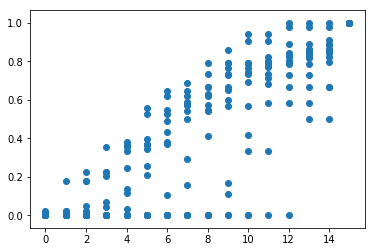

In [13]:
import matplotlib.pyplot as plt

plt.scatter(X,y)
plt.show()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0003   1.271625e+02   7.153261e+04 
    00s03  0004   8.836058e+01   5.961675e+03 
    00s10  0012  -3.175388e+01   2.239432e+00 
    00s13  0015  -3.238807e+01   8.469240e-03 
    00s16  0019  -3.239862e+01   1.764740e-04 
    00s19  0022  -3.239863e+01   4.823094e-06 
    00s21  0025  -3.239863e+01   2.861501e-10 
Runtime:     00s21
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,0.5711359326225871,+ve,
rbf.lengthscale,14.613863348876723,+ve,
Gaussian_noise.variance,0.04078001661655911,+ve,


 /Users/gcgibson/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1999: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


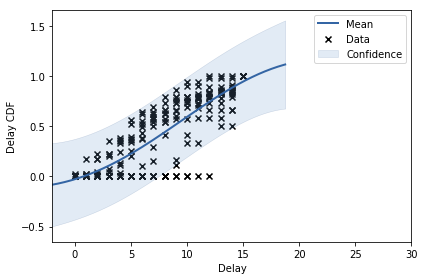

(array([[-0.02797894],
       [ 0.00969692],
       [ 0.05429889],
       [ 0.10555219],
       [ 0.16301077],
       [ 0.22606244],
       [ 0.29393947],
       [ 0.36573439],
       [ 0.44042042],
       [ 0.51687616],
       [ 0.59391332],
       [ 0.67030692],
       [ 0.74482662],
       [ 0.81626821],
       [ 0.88348416]]), array([[0.04206638],
       [0.04153353],
       [0.04128348],
       [0.0411892 ],
       [0.04116829],
       [0.0411738 ],
       [0.04118343],
       [0.04118915],
       [0.04118915],
       [0.04118343],
       [0.0411738 ],
       [0.04116829],
       [0.0411892 ],
       [0.04128348],
       [0.04153353]]))


In [17]:
import GPy
from IPython.display import display

X = np.array(X).reshape((-1,1))
y = np.array(y).reshape((-1,1))
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

m = GPy.models.GPRegression(X,y,kernel)
m.optimize(messages=True)
plt.clf()
plt.cla()
plt.close()
display(m)
fig = m.plot(xlim=(-2,30),ylabel="Delay CDF",xlabel="Delay")
GPy.plotting.show(fig, filename='basic_gp_regression_notebook_optimized')
plt.show()
print (m.predict(np.arange(15).reshape((-1,1))))